# $$\textbf{Dynamical friction}$$


We simulated the Dynamical Friction of a massive perturber (in black) on a system at equilibrium (Plummer Sphere, in blue).

<img src="sphere.gif" align="centre" width="600px"/>

In [1]:
import matplotlib
import numpy as np
import scipy
import math
import random
import os
import time
import glob
import pandas as pd
import scipy.integrate as integrate
import scipy.special as special
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

We started this simulation by initializating the particle positions following a Plummer sphere. We set the number of particles equal to $10^4 +1$ and arbitrarly choose to set the total mass and the mass of the perturber (for which we choose different masses to better understand this process).

# Setting the masses, number of masses and b parameter:

Here we set the masses of the stars and perturber (we here report only the one notebook with $m_{bh} = 0.03 M$. 

In [2]:
M = 1
N = 10**4 + 1
b = 1
m = M/N * np.ones(N)
G = 1
m_bh = 0.03*M
M = m_bh + m*(N-1)
m[0] = 0*m[0] + m_bh #array di masse. alla posizione 0 massa bh

# Initial positions

The Plummer sphere has a density profile
$$ \rho \left( R \right) = \frac{3 M_{tot}}{4\pi b^3}  \frac{1}{\left[1 + \left(\frac{r^2}{b^2}\right)\right]^{5/2}}$$ 
Inverting the relation for $M \left(R \right)/M_{tot}$ we obtain that 
$$
\begin{cases}
    R = b \sqrt{\left( \frac{ \xi^{2/3}}{1-\xi^{2/3}}\right)} && 0 \le \xi \le 1 \\ \\
    \varphi = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    \theta = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$

Initially, we defined the parameters: $\phi$, $\theta$ and the radius, we then plotted their distributions in three graphs.

In [18]:
r_cdf = np.random.uniform(0,1,N)
R = b * np.sqrt(r_cdf**(2/3)/(1- r_cdf**(2/3)))
theta_cdf = np.random.uniform(0,1,N)
theta = np.arccos(1 - 2 * theta_cdf)
phi = np.random.uniform(0, 2 * np.pi, size=N) 

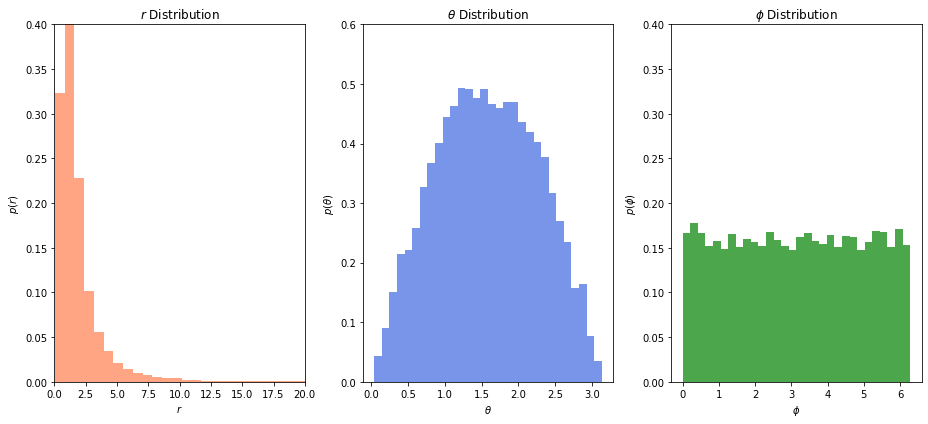

In [19]:
#Distribution of the three parameters in histograms
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(13, 6)) 

ax[0].hist(R, bins = 100, color = 'coral', density=True, alpha=.7, lw=0) 
ax[0].set(xlim=(0,20), ylim = (0,0.40), title = fr'$r$ Distribution', xlabel = r'$r$', ylabel=r'$p(r)$') 

ax[1].hist(theta, bins = 30, color = 'royalblue', density=True, alpha=.7, lw=0)
ax[1].set(ylim = (0,0.6), title = fr'$\theta$ Distribution', xlabel = r'$\theta$', ylabel=r'$p(\theta)$')

ax[2].hist(phi, bins = 30, color = 'green', density=True, alpha=.7, lw=0)
ax[2].set(ylim = (0,0.4), title = fr'$\phi$ Distribution', xlabel = r'$\phi$', ylabel=r'$p(\phi)$')
plt.show()

Write the parameters positions in cartesian coordinates.

In [20]:
x = R * np.cos(phi) * np.sin(theta)
y = R * np.sin(phi) * np.sin(theta)
z = R * np.cos(theta)

We show the 3D graph of our simulation, in purple the Plummer Sphere and in black the BH.

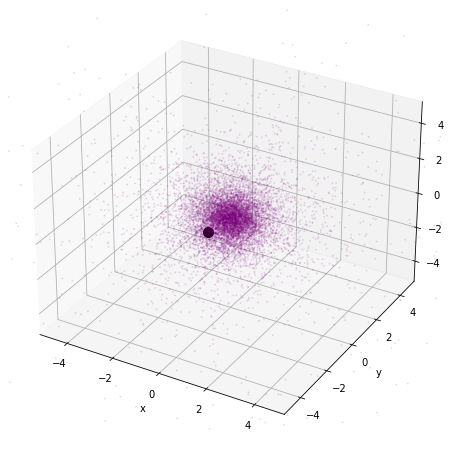

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)
ax.scatter(x[0], y[0], z[0], c = 'black', s= 0.5*m_bh/m[1], alpha=1)
ax.scatter(x, y, z, c = 'purple', s=1, alpha=0.1)
ax.set_aspect('auto')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

The potential for the Plummer sphere is:

$$\phi=\frac{-GM_{tot}}{\sqrt{r^2+b^2}}$$
The relative potential is:
$$\psi=-\phi+\phi_0=-\phi$$
We setted $\phi_0$ as zero.

In [22]:
Psi = G * M /(R**2 + b**2)**(1/2)

# Initial velocities
The velocity distribution is isotropic. For bound orbits $\vert \vec{v} \vert = q \sqrt{\Psi}$, where  $\Psi\left(\vec{x}\right) = -\phi\left(\vec{x}\right)$ and  $q$ is a position indipendent random number distributed with 
$$
 f(q) = A q^2 \left(1-q^2\right)
$$
- Compute the normalization constant
- sample q with the Montecarlo rejection method
- Compute the magnitude of the velocities.  $\vert \vec{v} \vert = q \sqrt{\Psi}$
Since the distribution is isotropic, it should form a sphere in velocity space.



$$
\begin{cases}
   \vert \vec{v} \vert = q \sqrt{\Psi} &&  0 \le q \le 1  && \text{with $f(q)$} \\ \\
    v_{\varphi} = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    v_{\theta} = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$


To switch to Cartesian coordinates, I use the following change of coordinates.

$$
\begin{cases}
   v_{x} = \vert \vec{v} \vert \cos(v_{\varphi}) \sin(v_{\theta}) \\
   v_{y} = \vert \vec{v} \vert \sin(v_{\varphi}) \sin(v_{\theta}) \\
   v_{z} = \vert \vec{v} \vert  \cos(v_{\theta})
\end{cases}
$$

In [23]:
pdf_test = lambda x: (x**2*(1-x**2)**(3.5))
A = integrate.quad(pdf_test,0,1)
q = np.linspace(0,1,100000)
pdf = 1/A[0]*(q**2*(1-q**2)**(3.5))
pdf_func = lambda x: 1/A[0]*(x**2*(1-x**2)**(3.5))
g = np.ones(100000)*np.max(pdf)

In [24]:
q_sample = []

for i in range(N):
    y_rand = np.max(g) + 1
    rand = np.random.uniform(0,1)
    while y_rand > pdf_func(rand):
        rand = np.random.uniform(0,1)
        y_rand = np.random.uniform(0,np.max(g))

    q_sample.append(rand)

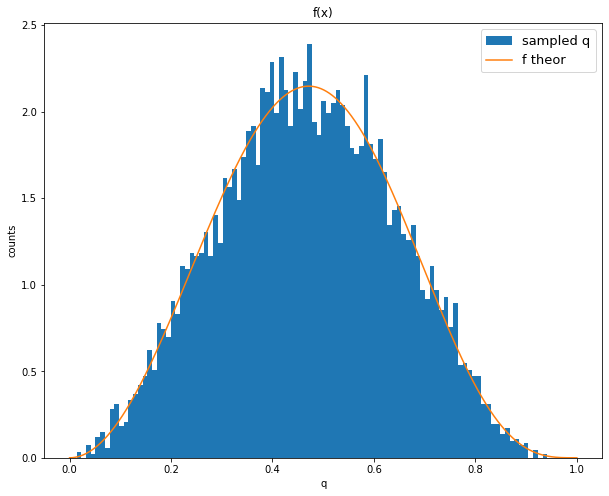

In [28]:
q_sample = np.array(q_sample)

plt.figure(figsize=(10, 8))
plt.hist(q_sample,100, density=True, label='sampled q')
plt.plot(q,pdf, label='f theor')
plt.xlabel('q')
plt.ylabel('counts')
plt.title('f(x)')
plt.legend(fontsize=13);

In [29]:
v = q_sample * np.sqrt(2 * Psi)
v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)
v_phi = np.random.uniform(0, 2 * np.pi, size=N) 


In [30]:
v_x = v * np.cos(v_phi) * np.sin(v_theta)
v_y = v * np.sin(v_phi) * np.sin(v_theta)
v_z = v * np.cos(v_theta)

We show the 3D simulation of the velocities.

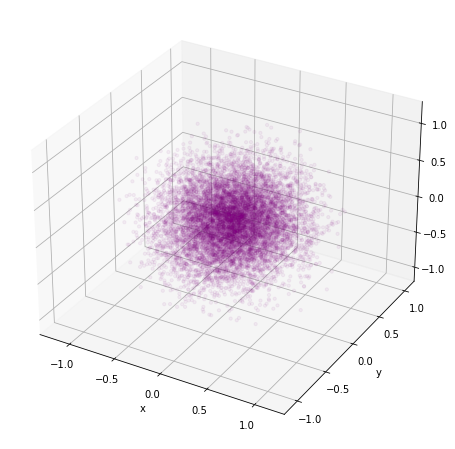

In [31]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
#ax.view_init(elev=90, azim=-90)
ax.scatter(v_x, v_y, v_z, c = 'purple', s=10.5, alpha = 0.05)
ax.set_aspect('auto')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#omega = np.linspace(0,2*np.pi,N)
#ax.plot(np.sqrt(2*np.max(Psi))*np.cos(omega),np.sqrt(2*np.max(Psi))*np.sin(omega), color='black', label='Q=1')
plt.show();

# Initial condition file

In [32]:
# creating the input file
m_arr = m 
dim = 3


with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

# Parameters

In [33]:
mask = R<b
V = 4/3 * np.pi * b**3
rho_ = np.sum(m_arr[mask])/ V
epsilon = 1/100 * (V/N)**(1/3)
T = np.sqrt(3 * np.pi/ (16* G * rho_) )
print(T*20)

52.73738442895409


In [34]:
T_sim = 20 * T
dt = 1/16
theta = 0.2
t_out = dt

---
Execute this cell only for new analysis!

---

In [52]:
M = 1
N = 10**4 + 1
b = 1
m = M/N * np.ones(N)
G = 1
m_bh = 0.03*M
M = m_bh + m[1]*(N-1)
m[0] = 0*m[0] + m_bh
filename = glob.glob('outdata*')
print(filename)

['outdata_10001_0.2_0.0625_0.03_52.78947074725871.txt', 'outdata_10001_0.2_0.0625_0.02_51.42799643114692.txt', 'outdata_10001_0.2_0.0625_0.01_53.07494314153892.txt', 'outdata.txt', 'outdata_10001_0.2_0.0625_0.05_48.90482634259716.txt', 'outdata_10001_0.2_0.0625_0.04_52.767129148989.txt', 'outdata_10001_0.2_0.0625_0.025_52.9241189004359.txt']


In [113]:
#Lettura dati
lines = pd.read_csv(filename[0], names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])


# Centre of mass

We computed the centre of mass of the sistem, we showed in a graph that it is not fixed in time.

In [88]:
#da sistemare
mu = m[3]/M
#mu = m[1]/M

x_cm = np.sum(mu*x_s, axis = 0)
y_cm = np.sum(mu*y_s, axis = 0)
z_cm = np.sum(mu*z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

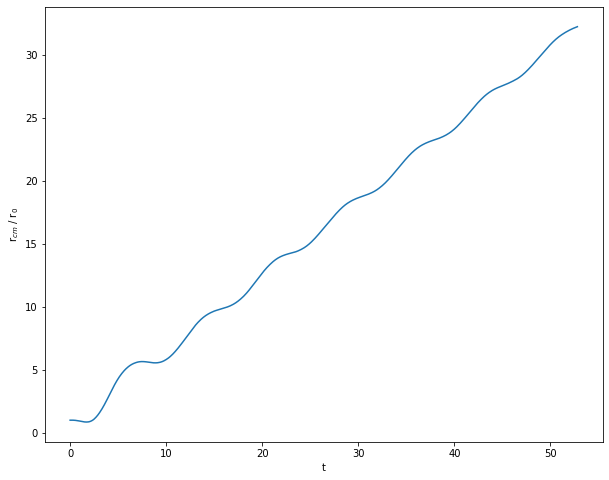

In [89]:
plt.figure(figsize=(10, 8))

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

We defined the radii by correcting it by subtracting the centre of mass:

In [90]:
r = np.sqrt((x_s-x_cm)**2 + (y_s-y_cm)**2 + (z_s-z_cm)**2)

# Density Profile

We analyzed the density profile for each timestep, startig by computing the volume of 1000 shells between zero and the maximum position of the particles. We, then, set a function in order to get the number of particles inside the shells at a fixed time.
We computed the density profile for each timestep, we sampled the mean density profile and its error by estimating the error on the number of particles obtained by the simulation.
In the end we quantified the propagation of the error to the density and we plotted the result.
In order to compute the average number of particles inside each shell by using the analytical density distribution we applied the following equation:

$$<particles> = \int_{r_1}^{r_2}4\pi r^2 \rho(r) dr$$
Note that the density profile of a Plummer sphere is:
$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$
So the integral becomes
$$<particles> = \int_{r_1}^{r_2} \frac{3M_{tot}}{b^3} r^2 (1+\frac{r^2}{b^2})^{-5/2} dr = \frac{3M_{tot}}{b^3} \frac{r^3}{3(1+\frac{r^2}{b^2})^{3/2}}$$ evaluated between $r_1$ and $r_2$.
For each particle we took $1 \sigma$ as the error, since it is Poissonian we used the square root of the number of particles: $\sqrt{N}$. 
In the end we found the error propagation of the density.

In [91]:
r_t     = np.transpose(r)
sampl   = 200
alpha   = b/10
p_error = []
X       = np.linspace(b/10, 2 * b, sampl)
rho_t   = []
m_ = M/N
for i in range(len(r_t)):
    rho     = []
    tmp_err = []
    for x in X:
        dr      = alpha * x 
        r_min   = (x - dr/2)
        r_max   = (x + dr/2) 
        V_shell = 4 * np.pi * dr * x**2 #Calcolo i volume della shell
        mask    = (r_t[i] > r_min) * (r_t[i] < r_max) # prendo i raggi compresi tra r_min e r_max
        n       = len(r_t[i][mask])
        
        rho.append(n * m_ / V_shell) #len(r_t[i][mask] è il numero di particelle dentro la shell
        tmp_err.append(np.sqrt(n)*m_/V_shell)
   
    rho_t.append(rho)
    p_error.append(tmp_err)

In [92]:
p_error = np.array(p_error)
tmp_err = np.array(tmp_err)
rho_t   = np.array(rho_t) # densità a diversi tempi
rho     = np.array(rho) #denisità a tempo = T_sim
rho_th  = 3* M /(4*np.pi*b**3) * 1/(1+(X**2/b**2))**(5/2)
rho_c   = 3* M /(4*np.pi*b**3) #densità centrale

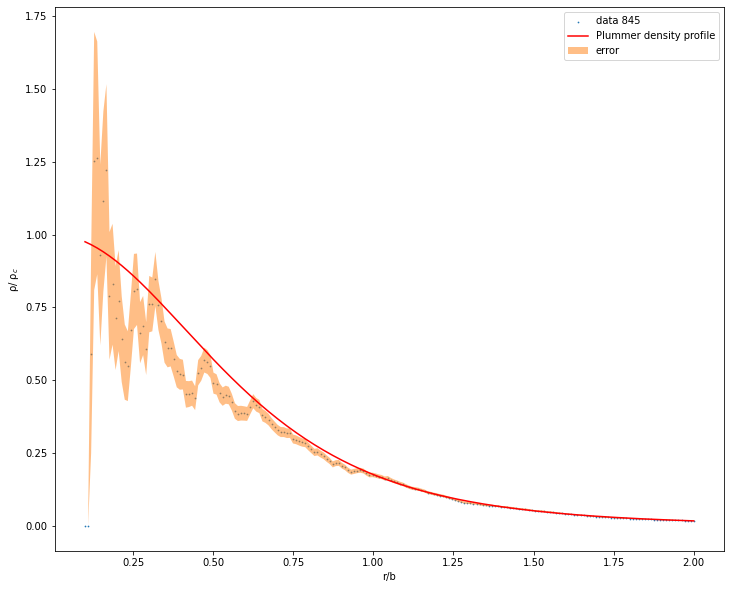

In [93]:
#plot della singola misura a T = T_sim. Normalizzo alla densità centrale 
t= len(r_t)-1

plt.figure(figsize=(12, 10))

plt.scatter(X,rho_t[t]/rho_c, s=0.5,label= 'data '+str(t))
plt.plot(X,rho_th/rho_c, c='red', label= 'Plummer density profile') 
plt.fill_between(X, rho_t[t]/rho_c - p_error[t]/rho_c, rho_t[t]/rho_c + p_error[t]/rho_c, alpha= 0.5, label= 'error')
#plt.yscale('log')
plt.ylabel('\u03C1/ \u03C1$_{c}$')
plt.xlabel('r/b')
plt.legend()
#plt.savefig('density_profile_t='+str(t)+'.eps', format='eps' )
plt.show()

We expect the data to converge to the analytical distribution, we then normalized for the central density profile.

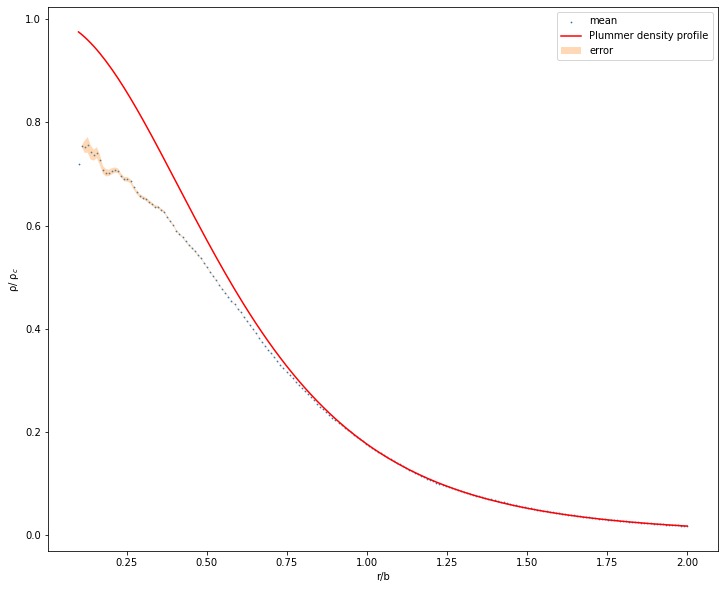

In [94]:
#Faccio la media sui tempi (è come se prendessi più misure del profilo di densità)
#I dati dovrebbero convergere alla distribuzione teorica
#Normalizzo per la rho_c
rho_mean = np.mean(rho_t,axis=0)
error = p_error[t]/np.sqrt(len(rho_t))

plt.figure(figsize=(12, 10))

plt.scatter(X,rho_mean/rho_c, s=0.5, label= 'mean')
plt.plot(X,rho_th/rho_c, c='red', label= 'Plummer density profile') 
plt.fill_between(X/b, rho_mean/rho_c - error/rho_c, rho_mean/rho_c + error/rho_c, alpha= 0.3, label='error')
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('\u03C1/ \u03C1$_{c}$')
plt.xlabel('r/b')
plt.legend()
#plt.savefig('density_profile_mean.eps', format='eps' )
plt.show()

Underestimation due to the presence of the big mass in the centre we didn't take into account?

# Lagrangian Radii

To have a better vision of the process we can introduce the Lagrangian Radii which are the radii containing a certain percentage of the total mass of the system (M_tot).
We checked if the radii are constant and we observed that they are not.

In [95]:
# notice: radius_array must be of shape [N_particles, N_time_output]
def Lagrangian_Radius(radius_array, quantile):
    
    L_radii = []
    
    # cycle over N_time_output
    for i in range(len(radius_array[0])):
        
        radii_sorted = np.sort(radius_array[:,i])
        mask = radii_sorted < np.quantile(radii_sorted, quantile)
        L_radii.append(np.max(radii_sorted[mask]))
        
    return np.array(L_radii)

# to find the lagrangian radius from theory

def Lagrangian_Theory(b, quantile): 
    
    rad3_cb3 = (quantile * b**3)**(1/3)
    
    return rad3_cb3 / (1 - 1 / b**2 * rad3_cb3**2)**(1/2)

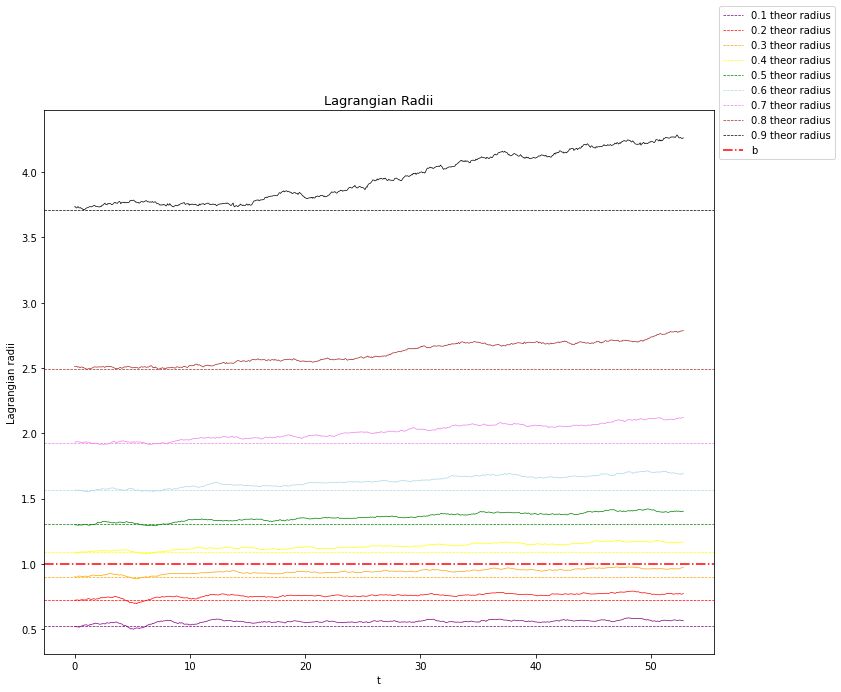

In [96]:
quantiles = np.linspace(0.1, 0.9, 9)

std = []

c = ['purple', 'red', 'orange', 'yellow', 'green', 'lightblue', 'violet', 'brown', 'black']

plt.figure(figsize=(12, 10))

for q, color in zip(quantiles, c):
    
    L = Lagrangian_Radius(r, round(q,1))
    std.append(np.var(L)**0.5)
    
    #plt.plot(t_s, L, label='q ='+str(round(q,1)))  , yerr=std[-1], xerr=None
    plt.plot(t_s, L, c=color, linewidth=0.7, alpha=1)   
    plt.axhline(Lagrangian_Theory(b, q), linestyle='--', label=f'{q:.1f} theor radius', c=color, linewidth=0.7, alpha=1)
    
plt.axhline(b, label='b', color='red', linestyle='-.')
plt.ylabel('Lagrangian radii')
plt.xlabel('t')
plt.title('Lagrangian Radii', fontsize=13)
plt.legend(bbox_to_anchor=(1., 1.2));

# Velocities

We computed the absolute value of the velocities for every direction and we plotted the result.

In [97]:
def find_vs_module(vx_s, vy_s, vz_s): 
    
    return np.sqrt(vx_s**2 + vy_s**2 + vz_s**2)

In [98]:
mod_v_s = find_vs_module(vx_s, vy_s, vz_s)

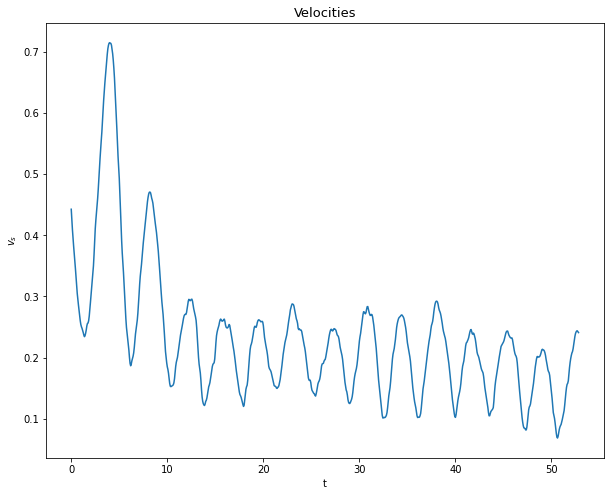

In [99]:
plt.figure(figsize=(10, 8))

plt.plot(t_s, mod_v_s[0])
plt.ylabel('$v_s$')
plt.xlabel('t')
plt.title('Velocities', fontsize=13); 

# Perturber Mass 

We then studied the movement of the BH mass. 
Firstly, we plotted the motion of the BH respect to the simulation time.

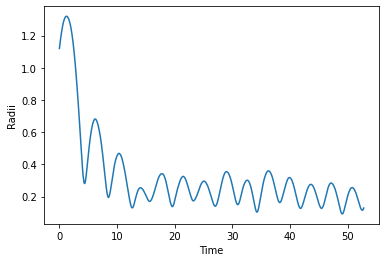

In [100]:
plt.plot(t_s,r[0]/b)
plt.xlabel('Time')
plt.ylabel('Radii')
plt.show()

We found the average radii and time and we plotted the result over the previous graph, using the definition of mean value of a function over an interval: 

$$<R> = \frac{1}{t_{max} - t_{min}} \int_{t_{min}}^{t_{max}} r(t) dt $$

In [101]:
def find_average_r_nice(r_s, N_intervals): 
    
    r_mean = []
    t_mean = []
    
    step = int(len(t_s)/N_intervals)
    remaining = len(t_s)%N_intervals

    for n in np.arange(0, len(t_s) - remaining, step):
        
        tmin = t_s[n]
        tmax = t_s[n+step]
        
        r_mean.append(1/(tmax-tmin) * np.trapz(r_s[n:n+step], t_s[n:n+step]))
        t_mean.append((tmax + tmin)/2)
        
    return t_mean, r_mean

In [102]:
 t_mean, r_mean = find_average_r_nice(r[0]/b, 20)

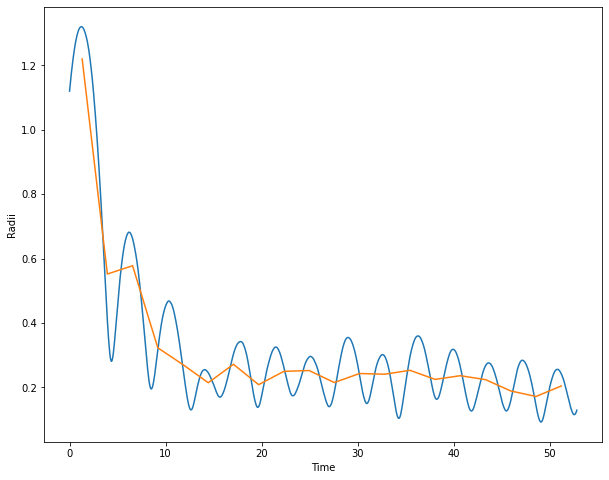

In [103]:
plt.figure(figsize=(10, 8))

plt.plot(t_s,r[0]/b)
plt.plot(t_mean, r_mean)
plt.xlabel('Time')
plt.ylabel('Radii')
plt.show()

In [104]:
def find_t_qualitative(t_mean, r_mean): 
    
    t_arg = np.argwhere(np.array(r_mean) < 0.2 * (r[0]/b)[0])[0][0]  # when 20% of the initial radius
    
    return t_mean[t_arg]

We defined the collapse time. 

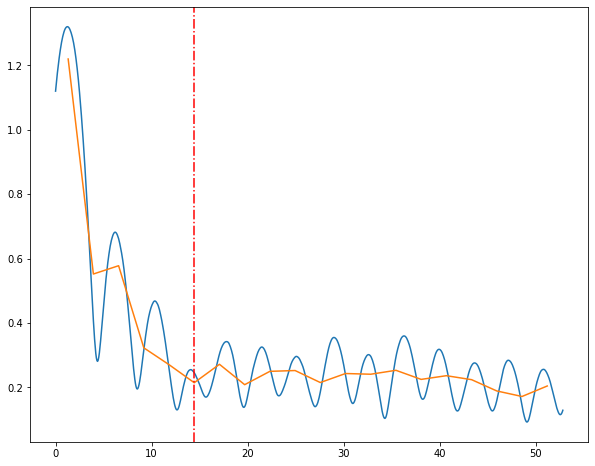

In [105]:
time_coll = find_t_qualitative(t_mean, r_mean)

plt.figure(figsize=(10, 8))

plt.plot(t_s,r[0]/b)
plt.plot(t_mean, r_mean)
plt.axvline(find_t_qualitative(t_mean, r_mean), c='r', linestyle='-.');

In [106]:
print("The mass of the BH is:", m_bh)
print("The collapse time is:", time_coll)

The mass of the BH is: 0.02
The collapse time is: 14.4375


# Angular Momentum

In the end we studied the evolution of the angular momentum of the perturber.
$$L = Mrv$$
With M the mass of the perturber, r the radius of the perturber and v the velocity of the perturber corrected with the centre of mass.

In [107]:
def find_L(r_s, M, v_s):
    
    return M * r_s * v_s

In [108]:
l_s = find_L(r[0], m_bh, mod_v_s[0])

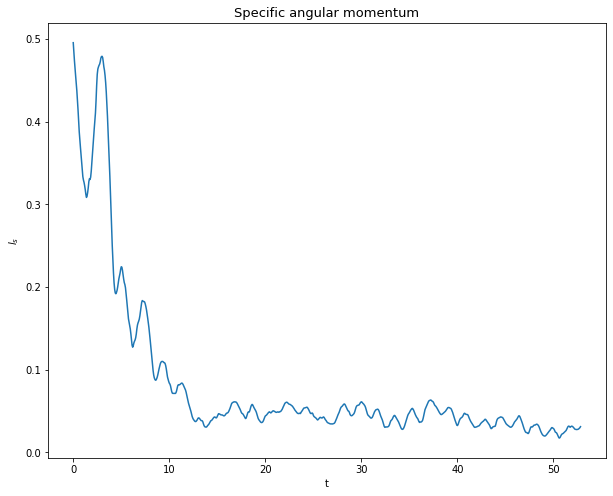

In [109]:
plt.figure(figsize=(10, 8))
plt.plot(t_s,l_s/m_bh)

plt.ylabel('$l_s$')
plt.xlabel('t')
plt.title('Specific angular momentum', fontsize=13);

# Evolution of collapse ? Time with respect to the perturber's mass.

Now we wanted to show how the collapse time changes respect to the mass of the perturber. We choose different masses for the perturber and we computed its collapse time, we then plotted in a graph the result.

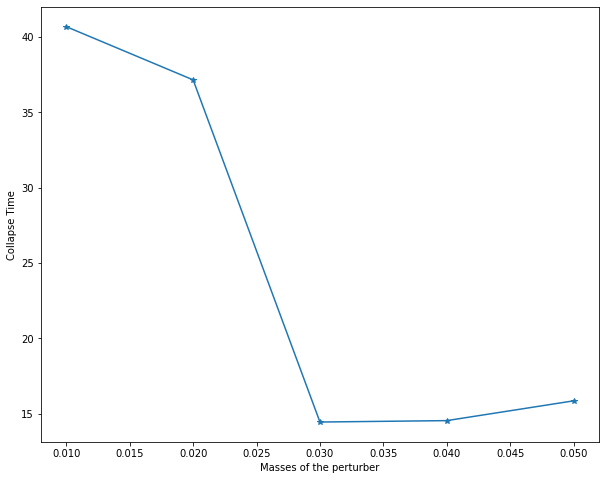

In [112]:
m_bh_arr = [0.01, 0.02, 0.03, 0.04, 0.05]
t_coll_arr = [40.6875, 37.15625, 14.4375, 14.53125, 15.84375]

#graph of the trend 
plt.figure(figsize=(10, 8))
plt.plot(m_bh_arr, t_coll_arr, marker='*')
plt.xlabel('Masses of the perturber')
plt.ylabel('Collapse Time')
plt.show()

From the previous graph we can observe that the collapse time tends to become shorter while the mass increase. 
Even though we can clearly see by eye that the last collapse time slightly increase instead of decreasing, this is due probably to the fact that every time we start a simulation with different masses of the perturber, it does not start from the same position, or it could be due to some overstimation of the parameters.

# Animation


100%|████████████████████████████████████████▉| 845/846 [13:16<00:00,  1.06it/s]

 23%|█████████▎                               | 193/846 [01:45<05:29,  1.98it/s]


 46%|██████████████████▊                      | 387/846 [03:26<03:40,  2.09it/s]


 69%|████████████████████████████▏            | 581/846 [05:21<02:49,  1.56it/s]


 92%|█████████████████████████████████████▌   | 775/846 [07:26<00:44,  1.59it/s]


100%|████████████████████████████████████████▉| 845/846 [08:11<00:00,  1.59it/s]

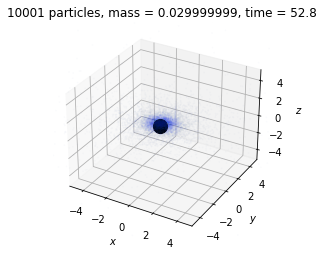

In [114]:
# simulation
from matplotlib import animation
from tqdm import tqdm

def update(num):
    global N    #N_particles
    l = 5
    ax.clear()
    ax.scatter(x_s[0:1,num-1], y_s[0:1,num-1], z_s[0:1,num-1], color = 'black', s = m_bh/m[2] ,alpha = 1 )
    ax.scatter(x_s[1:2,num-1], y_s[1:2,num-1], z_s[1:2,num-1], color = 'royalblue', s = 1 ,alpha = 0.01 )
    ax.scatter(x_s[2:,num-1], y_s[2:,num-1], z_s[2,num-1], color = 'royalblue' , s = 1 ,alpha = 0.01 )        # Updating Point Location

    ax.set_title(f'{N} particles, mass = {m_s[0,0]}, time = {round(t_s[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)
    

## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='auto')
line_ani = animation.FuncAnimation(fig, update, interval=1,   
                                   frames=tqdm(range(len(t_s))))

# Saving the Animation
f = r"sphere_1.gif"
writergif = animation.PillowWriter(fps=30)
line_ani.save(f, writer=writergif, dpi=200)

plt.show()